# CIFAR-10简介

CIFAR-10是一个更接近普适物体的彩色图像数据集,由Hinton的学生Alex Krizhevsky和Ilya Sutskever整理的一个用于识别普适物体的小型数据集。

包含10个类别：

飞机（airplane）、汽车（automobile）、鸟类（bird）、猫（cat）、鹿（deer）、狗（dog）、蛙类（frog）、马（horse）、船（ship）和卡车（truck）。

每个图片的尺寸为32×32 ，每个类别有6000个图像，数据集中一共有50000 张训练图片和10000 张测试图片。

# 与MNIST数据集相比，CIFAR-10 有以下不同点
- (1)CIFAR-10是3通道的彩色RGB图像，而MNIST是灰度图像。
- (2)CIFAR-10图片尺寸：32×32，而MNIST的图片尺寸：28×28，比MNIST稍大。
- (3)相比于手写字符，CIFAR-10含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、特征都不尽相同，这为识别带来很大困难。
   直接的线性模型如Softmax 在CIFAR-10上表现得很差。

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# -----------------------------------导入数据-----------------------------------
trainset = torchvision.datasets.CIFAR10(root='', train=True, download=False, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='', train=False, download=False, transform=transforms.ToTensor())

batch_size = 100  
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

In [5]:
print(type(trainset))
print('-----------------------------------------------------')
print(trainset)
print('-----------------------------------------------------')
print(type(testset))
print('-----------------------------------------------------')
print(testset)
print('-----------------------------------------------------')

<class 'torchvision.datasets.cifar.CIFAR10'>
-----------------------------------------------------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()
-----------------------------------------------------
<class 'torchvision.datasets.cifar.CIFAR10'>
-----------------------------------------------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()
-----------------------------------------------------


In [6]:
print('------------------数据中数字对应的类别------------------')
print(testset.class_to_idx)
print('------------------数据中的类别------------------') 
print(testset.classes) 

------------------数据中数字对应的类别------------------
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
------------------数据中的类别------------------
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
print(type(train_loader))
print('-----------------------------------------------------')
print(train_loader)

<class 'torch.utils.data.dataloader.DataLoader'>
-----------------------------------------------------


In [8]:
train_data, train_label = next(iter(train_loader))
test_data, test_label = next(iter(test_loader))

print('【方式一】返回2个' + str(type(train_data)) + '的变量')
print('【训练集的特征大小】：',train_data.shape)
print('【训练集的标签大小】：',train_label.shape)
print('【验证集的特征大小】：',test_data.shape)
print('【验证集的标签大小】：',test_label.shape)

【方式一】返回2个<class 'torch.Tensor'>的变量
【训练集的特征大小】： torch.Size([100, 3, 32, 32])
【训练集的标签大小】： torch.Size([100])
【验证集的特征大小】： torch.Size([100, 3, 32, 32])
【验证集的标签大小】： torch.Size([100])


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 自定义函数：可视化张量 ---> 显示图片
def imshow(inp,cmap=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)

tensor(7)


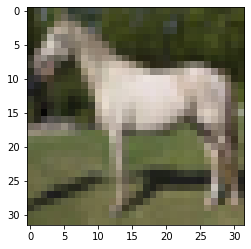

In [12]:
imshow(train_data[90])
print(train_label[90])

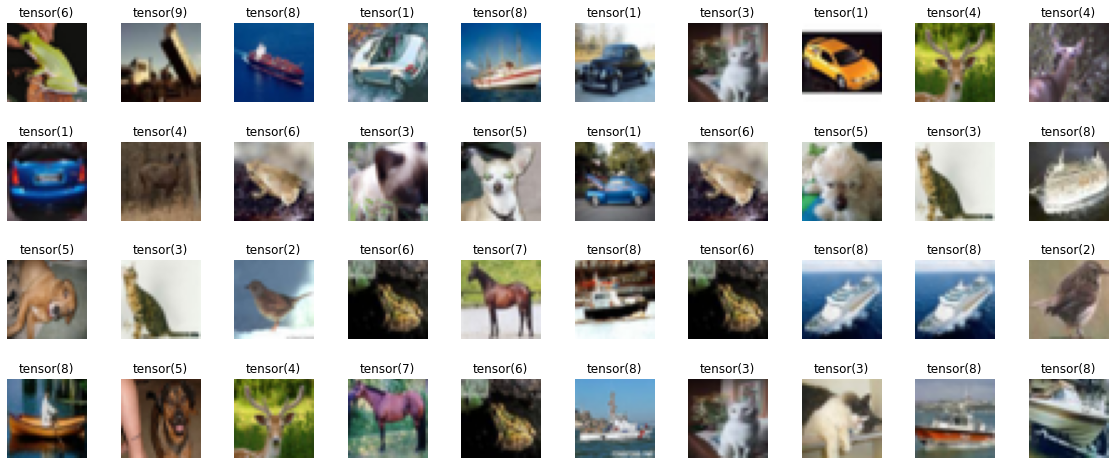

In [11]:
# 查看验证集的多张照片
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 2, n_rows * 2))
for row in range(n_rows):
    for col in range(n_cols):
        index = np.random.randint(1,100)
        plt.subplot(n_rows, n_cols, n_cols * row + col + 1)    # 设置图片的个数
        imshow(train_data[index])
        plt.axis('off')
        plt.title(train_label[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------------------超参数初始化------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
thresh = 0.5                     # 神经元的阈值：neuronal-threshold
decay = 0.2                      # 衰减常数：decay-constants
lens = 0.5                       # 近似函数的超参数：hyper-parameters of approximate function
# num_classes = 10                 # 分类的种类数目：10个
learning_rate = 1e-3             # 学习率lr
num_epochs = 100                 # 训练次数：最大值100

In [3]:
# ------------------------------------------定义近似激发函数------------------------------------------
class ActFun(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.gt(thresh).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        temp = abs(input - thresh) < lens
        return grad_input * temp.float()
    
act_fun = ActFun.apply

# ------------------------------------------膜电位更新函数------------------------------------------
# ops：层      x：输入    mem：膜电位     spike：尖峰电压
def mem_update(ops, x, mem, spike):
#     print('x:', x.size())
#     print('mem:', mem.size())
#     print('spike:', spike.size())
    
    mem = mem * decay * (1. - spike) + ops(x)
    spike = act_fun(mem)
    return mem, spike

# -----------------------------------------衰减学习率lr函数-----------------------------------------
# 【说明】每十进制一个新纪元衰减0.1倍的学习速率。
def lr_scheduler(optimizer, epoch, init_lr=0.1, lr_decay_epoch=50): 
    if epoch % lr_decay_epoch == 0 and epoch > 1:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.1
    return optimizer

In [4]:
# 卷积层Conv2d对应的参数(in_planes, out_planes, stride, padding, kernel_size)
cfg_cnn = [(3, 128, 1, 1, 3),
           (128, 256, 1, 1, 3),
           (256, 512, 1, 1, 3)]
# 卷积核
cfg_kernel = [32, 16, 8, 4]
# fc layer
cfg_fc = [512, 10]

class SCNN(nn.Module):
    def __init__(self):
        super(SCNN, self).__init__()
        in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[0]
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)
        in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[1]
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)
        in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[2]
        self.conv3 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)

        self.fc1 = nn.Linear(cfg_kernel[-1] * cfg_kernel[-1] * cfg_cnn[-1][1], 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, input, time_window = 20):
        # -------------------------------1.膜电位mem与尖峰电压spike初始化-------------------------------
        c1_mem = c1_spike = torch.zeros(batch_size, cfg_cnn[0][1], cfg_kernel[0], cfg_kernel[0], device=device)   
        c2_mem = c2_spike = torch.zeros(batch_size, cfg_cnn[1][1], cfg_kernel[1], cfg_kernel[1], device=device)
        c3_mem = c3_spike = torch.zeros(batch_size, cfg_cnn[2][1], cfg_kernel[2], cfg_kernel[2], device=device)
        h1_mem = h1_spike = h1_sumspike = torch.zeros(batch_size, cfg_fc[0], device=device)
        h2_mem = h2_spike = h2_sumspike = torch.zeros(batch_size, cfg_fc[1], device=device)
        
        # -------------------------------2.模拟时间-----------------------------------------------------
        for step in range(time_window): # 时间窗=20次
            # ---------------------------2.1 随机生成数字---> 第一次膜电位更新(conv1)--------------
            x = input > torch.rand(input.size(), device=device) # prob. firing
            c1_mem, c1_spike = mem_update(self.conv1, x.float(), c1_mem, c1_spike)
#             print('-----------------------conv1膜电位更新完成-----------------------')
            # ---------------------------2.2 平均池化层 ---> 第二次膜电位更新(conv2)---------------
            x = F.avg_pool2d(c1_spike, 2)
            c2_mem, c2_spike = mem_update(self.conv2,x, c2_mem,c2_spike)
#             print('-----------------------conv2膜电位更新完成-----------------------')
            x = F.avg_pool2d(c2_spike, 2)
            c3_mem, c3_spike = mem_update(self.conv3,x, c3_mem,c3_spike)
            # ---------------------------2.3 平均池化层 ---> 视图展开------------------------------
            x = F.avg_pool2d(c3_spike, 2)
            x = x.view(batch_size, -1)
            # ---------------------------2.4 第三次膜电位更新(fc1) ---> 第四次膜电位更新(fc2)------
            h1_mem, h1_spike = mem_update(self.fc1, x, h1_mem, h1_spike)
#             print('-----------------------fc1膜电位更新完成-----------------------')
            h1_sumspike += h1_spike
            h2_mem, h2_spike = mem_update(self.fc2, h1_spike, h2_mem,h2_spike)
#             print('-----------------------fc2膜电位更新完成-----------------------')
            h2_sumspike += h2_spike

        outputs = h2_sumspike / time_window
        return outputs

In [ ]:
from __future__ import print_function
import torchvision
import torchvision.transforms as transforms

# ------------------------------------------相关参数初始化------------------------------------------
best_acc = 0                    # 最佳准确率acc
start_epoch = 0                 # 循环epoch起始点
epoch_record = list([])
train_loss_record = list([])
test_acc_record = list([])           # 历史记录：准确率acc
test_loss_record = list([])

# ------------------------------------------SCNN网络初始化------------------------------------------
snn = SCNN()
snn.to(device)
criterion = nn.MSELoss()    # 均方误差MSE
optimizer = torch.optim.Adam(snn.parameters(), lr=learning_rate)   # 动量类型的梯度下降法

# ---------------------------------------------模型训练---------------------------------------------
for epoch in range(num_epochs):
    running_loss = 0
    train_loss = 0
    test_loss = 0
    start_time = time.time()  
    
    # ----------------------------------------------1.利用【训练集】进行训练----------------------------------------------
    for i, (images, labels) in enumerate(train_loader):
        # ---------------------------1.1 梯度初始化-------------------------------------
        snn.zero_grad()        
        optimizer.zero_grad()   
        # ---------------------------1.2 将数据转换成模型可以使用的类型-----------------
        images = images.float().to(device)
        labels_ = torch.zeros(batch_size, 10).scatter_(1, labels.view(-1, 1), 1)
        # ---------------------------1.3 将数据载入模型，获取输出-----------------------
        outputs = snn(images)
        # ---------------------------1.4 计算损失---------------------------------------
        loss = criterion(outputs.cpu(), labels_)
        running_loss += loss.item()
        train_loss += loss.item()
        # ---------------------------1.5 反向传播+更新权重------------------------------
        loss.backward()
        optimizer.step()
        
        # ---------------------------1.6 打印批处理的结果-------------------------------
        # 【说明】因为训练集60000个，每次批处理100个数据；所以每次epoch需要进行600次批处理，而我们需要每进行100次批处理打印一下结果。
        if (i+1)%100 == 0:
             print ('Epoch [%d/%d], Step [%d/%d], Train-Loss: %.5f'
                    %(epoch+1, num_epochs, i+1, len(trainset)//batch_size,running_loss ))
             running_loss = 0
             print('Time elasped:', time.time()-start_time)   
    
    train_loss_record.append(train_loss)
    train_loss = 0
    # 初始化参数
    correct = 0   # 统计：下面进行测试中正确的个数
    total = 0     # 统计：下面进行测试中样本的总个数
    # 调整学习率
    optimizer = lr_scheduler(optimizer, epoch, learning_rate, 40)    
    
    
    # ----------------------------------------------2.利用【测试集】进行测试----------------------------------------------
    # 100*100=10000张
    # with torch.no_grad()或者@torch.no_grad()中的数据不需要计算梯度，也不会进行反向传播，（torch.no_grad()是新版本pytorch中volatile的替代）
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            # ---------------------------2.1 梯度初始化-------------------------------------
            optimizer.zero_grad()
            # ---------------------------2.2 将数据转换成模型可以使用的类型-----------------
            inputs = inputs.to(device)
            labels_ = torch.zeros(batch_size, 10).scatter_(1, targets.view(-1, 1), 1)
            # ---------------------------2.3 将数据载入模型，获取输出-----------------------
            outputs = snn(inputs)
            # ---------------------------2.4 计算损失---------------------------------------
            loss = criterion(outputs.cpu(), labels_)
            test_loss += loss.item()
            # ---------------------------2.5 统计样本数量及正确个数-------------------------
            _, predicted = outputs.cpu().max(1)
            total += float(targets.size(0))
            correct += float(predicted.eq(targets).sum().item())
            # ---------------------计算第0次batch_idx中0~100测试集的正确率acc---------------
            if batch_idx %100 ==0:
                test_acc = 100. * float(correct) / float(total)
                print(batch_idx, len(test_loader),' Test-Acc: %.5f' % test_acc)
                
    test_acc = 100 * correct / total        
    print('Test Accuracy of the model on the 10000 test images: %.3f' % test_acc,'\n')
    test_acc_record.append(test_acc)                      # 记录每一轮epoch中在测试集中的准确度
    test_loss_record.append(test_loss)
    test_loss = 0
    
    epoch_record.append(epoch)
    history_dic = {
        'epoch_list': epoch_record,
        'train_loss_list': train_loss_record,
        'test_acc_list': test_acc_record,
        'test_loss_list': test_loss_record
    }

Epoch [1/100], Step [100/500], Train-Loss: 10.64102
Time elasped: 56.20961260795593
Epoch [1/100], Step [200/500], Train-Loss: 9.16667
Time elasped: 112.45132374763489
Epoch [1/100], Step [300/500], Train-Loss: 8.63016
Time elasped: 168.6838662624359
Epoch [1/100], Step [400/500], Train-Loss: 8.12970
Time elasped: 224.84655165672302
Epoch [1/100], Step [500/500], Train-Loss: 7.65976
Time elasped: 281.010272026062
0 100  Test-Acc: 51.00000
Test Accuracy of the model on the 10000 test images: 38.250 

Epoch [2/100], Step [100/500], Train-Loss: 7.37250
Time elasped: 56.01802372932434
Epoch [2/100], Step [200/500], Train-Loss: 7.22300
Time elasped: 112.18670153617859
Epoch [2/100], Step [300/500], Train-Loss: 6.83409
Time elasped: 168.36246919631958
Epoch [2/100], Step [400/500], Train-Loss: 6.87830
Time elasped: 224.5375726222992
Epoch [2/100], Step [500/500], Train-Loss: 6.67380
Time elasped: 280.7149450778961
0 100  Test-Acc: 49.00000
Test Accuracy of the model on the 10000 test images:

Epoch [17/100], Step [200/500], Train-Loss: 1.83081
Time elasped: 112.40415143966675
Epoch [17/100], Step [300/500], Train-Loss: 1.83584
Time elasped: 168.6774492263794
Epoch [17/100], Step [400/500], Train-Loss: 1.92236
Time elasped: 224.95103454589844
Epoch [17/100], Step [500/500], Train-Loss: 1.98043
Time elasped: 281.2248742580414
0 100  Test-Acc: 65.00000
Test Accuracy of the model on the 10000 test images: 69.760 

Epoch [18/100], Step [100/500], Train-Loss: 1.62582
Time elasped: 56.12655186653137
Epoch [18/100], Step [200/500], Train-Loss: 1.68274
Time elasped: 112.4021646976471
Epoch [18/100], Step [300/500], Train-Loss: 1.74545
Time elasped: 168.67918992042542
Epoch [18/100], Step [400/500], Train-Loss: 1.79329
Time elasped: 224.9537181854248
Epoch [18/100], Step [500/500], Train-Loss: 1.86865
Time elasped: 281.2232348918915
0 100  Test-Acc: 71.00000
Test Accuracy of the model on the 10000 test images: 69.920 

Epoch [19/100], Step [100/500], Train-Loss: 1.52278
Time elasped:

In [ ]:
import matplotlib.pyplot as plt

# 可视化：准确率accuracy  acc_record
plt.plot(range(1,len(history_dic['train_loss_list'])+1),history_dic['train_loss_list'],'r',label = 'train_loss_list')
plt.legend()

In [ ]:
plt.plot(range(1,len(history_dic['test_loss_list'])+1),history_dic['test_loss_list'],'b',label = 'test_loss_list')
plt.legend()

In [ ]:
plt.plot(range(1,len(history_dic['test_acc_list'])+1),history_dic['test_acc_list'],'g',label = 'test_acc_list')
plt.legend()